

Stage 1: Bottleneck Identification Notebook
------------------------------------------------



## 1. Load libraries and check for DTW support
We import the required libraries for preprocessing, clustering, and evaluation. We also attempt to import `cdist_dtw` from `tslearn` to use DTW as our distance metric.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score
)

# Try DTW
try:
    from tslearn.metrics import cdist_dtw
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance
    DTW_AVAILABLE = True
except ImportError:
    DTW_AVAILABLE = False


## 2. Load production data from Excel and perform initial cleanup
We ensure that key columns exist and drop records with missing bottleneck durations. We also create a binary flag `is_active` to represent active stoppage states.


In [2]:
import pandas as pd

# === Data Loading & Cleaning ===
FILEPATH = r"C:\Users\pbrin\Downloads\DATA WIP SORTED BASED ON ACTIVE STATE.xlsx"
df = pd.read_excel(FILEPATH, parse_dates=['Start Datetime', 'End Datetime'])

# Check for required columns
required_cols = ['Line', 'Stoppage Category', 'Stoppage Reason', 'Shift Id', 'Bottleneck Duration Seconds']
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise KeyError(f"Missing column(s): {missing}")

# Drop rows with missing bottleneck duration
df.dropna(subset=['Bottleneck Duration Seconds'], inplace=True)

# Create active flag (1 = active, 0 = not occupied)
df['is_active'] = (df['Stoppage Category'] != 'Not Occupied').astype(int)


## 3. Remove extreme outliers using IQR
We use the interquartile range (IQR) method to filter out bottleneck durations that fall far outside the expected range.


In [3]:
# === 3. Advanced Preprocessing ===

# --- Remove extreme outliers using IQR ---
Q1 = df['Bottleneck Duration Seconds'].quantile(0.25)
Q3 = df['Bottleneck Duration Seconds'].quantile(0.75)
IQR = Q3 - Q1

# Keep only values within 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[df['Bottleneck Duration Seconds'].between(lower_bound, upper_bound)]

# --- (Optional) Smooth durations with rolling median per line ---
# Uncomment below to apply smoothing
# df['Bottleneck_Smooth'] = (
#     df.groupby('Line')['Bottleneck Duration Seconds']
#     .transform(lambda x: x.rolling(window=5, center=True, min_periods=1).median())
# )


## 4. Generate summary statistics and extract group-level time series
We summarize statistics for each `(Line, Stoppage Reason, Shift Id)` group and create a time series dictionary for clustering.


In [4]:
# === 4. Summary & Time-Series Extraction ===

# --- Summary statistics per (Line, Reason, Shift) ---
stats = (
    df.groupby(['Line', 'Stoppage Reason', 'Shift Id'])['Bottleneck Duration Seconds']
    .agg(['mean', 'std', 'min', 'max', 'count'])
    .rename(columns={'count': 'length'})
    .dropna()
)

# --- Extract time series per group (for DTW) ---
# Only include groups with more than 1 record
ts_dict = {
    key: grp.sort_values('Start Datetime')['Bottleneck Duration Seconds'].values
    for key, grp in df.groupby(['Line', 'Stoppage Reason', 'Shift Id'])
    if len(grp) > 1
}


## 5a. Compute DTW distance matrix
We scale and pad all time series, then compute pairwise DTW distances using `tslearn.metrics.cdist_dtw`.


C:\Users\pbrin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\pbrin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


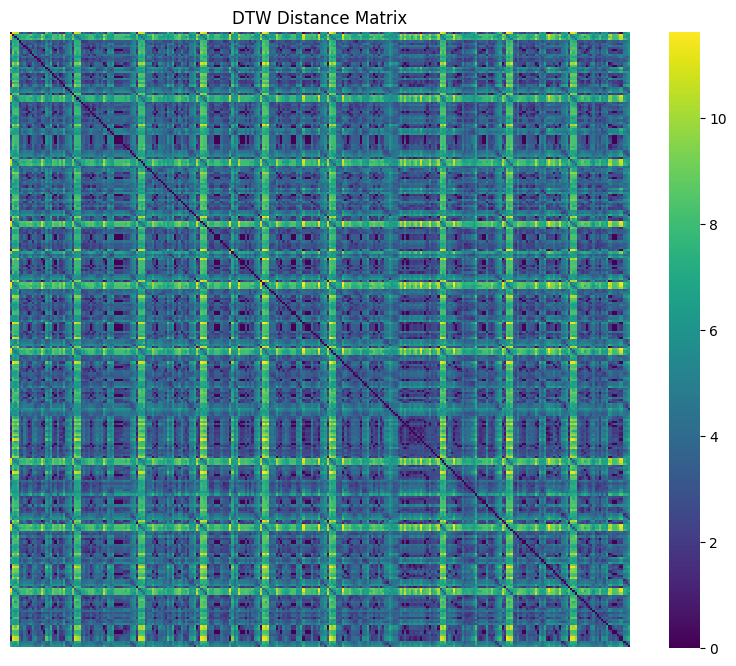

,Cluster,Line,Stoppage Reason,Shift Id
0,0,Line 1,Bellow Replacement,B
1,2,Line 1,CIL,A
2,3,Line 1,CIL,B
3,1,Line 1,CIL,C
4,0,Line 1,Cube Breakage,A
...,...,...,...,...
275,0,Line 9,Running,B
276,0,Line 9,Running,C
277,0,Line 9,SHO,A
278,0,Line 9,SHO,B


In [5]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

if DTW_AVAILABLE:
    # --- Extract values and keys ---
    X_ts = list(ts_dict.values())
    ts_keys = list(ts_dict.keys())

    # --- Convert to padded time series dataset ---
    X_ts_padded = to_time_series_dataset(X_ts)

    # --- Normalize (zero mean, unit variance) ---
    scaler = TimeSeriesScalerMeanVariance()
    X_ts_scaled = scaler.fit_transform(X_ts_padded)

    # --- Compute DTW distance matrix ---
    D_dtw = cdist_dtw(X_ts_scaled)

    # --- Visualize DTW distance matrix ---
    plt.figure(figsize=(10, 8))
    sns.heatmap(D_dtw, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title("DTW Distance Matrix")
    plt.show()

    # --- Agglomerative Clustering ---
    n_clusters = 4  # Modify if needed
    model = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage='average'
    )
    labels = model.fit_predict(D_dtw)

    # --- Assign clusters back to group keys ---
    cluster_assignments = pd.DataFrame({
        'Group': ts_keys,
        'Cluster': labels
    })
    cluster_assignments[['Line', 'Stoppage Reason', 'Shift Id']] = pd.DataFrame(
        cluster_assignments['Group'].tolist(), index=cluster_assignments.index
    )
    cluster_assignments.drop(columns='Group', inplace=True)

    display(cluster_assignments)

else:
    print("DTW is not available. Please install tslearn using: pip install tslearn")


## 5b. Visualize the DTW distance matrix
A heatmap shows how similar each pair of time series is, based on their DTW distance.


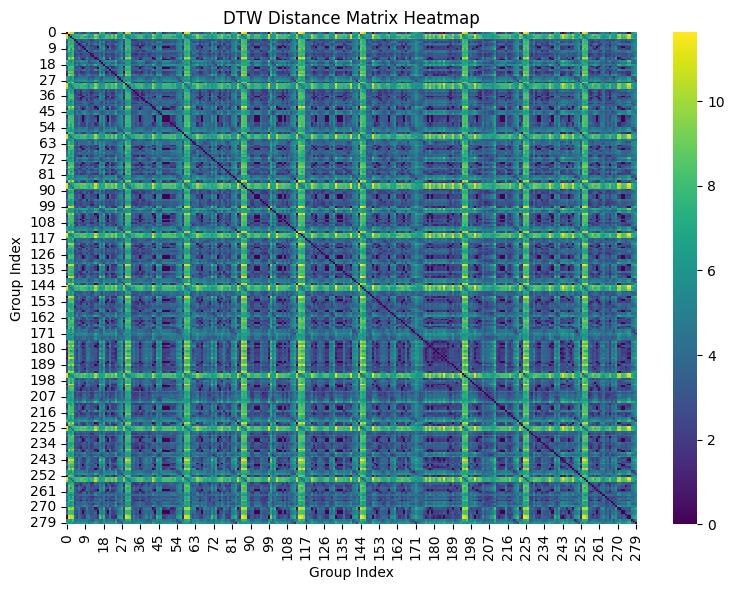

In [6]:
# 5b. Distance Matrix Heatmap (DTW only)
plt.figure(figsize=(8, 6))
sns.heatmap(D_dtw, cmap='viridis')
plt.title('DTW Distance Matrix Heatmap')
plt.xlabel('Group Index')
plt.ylabel('Group Index')
plt.tight_layout()
plt.show()


## 5c. Visualize hierarchical clustering via dendrogram
We use `scipy.cluster.hierarchy.linkage` and `dendrogram` to display the clustering tree based on DTW distances.


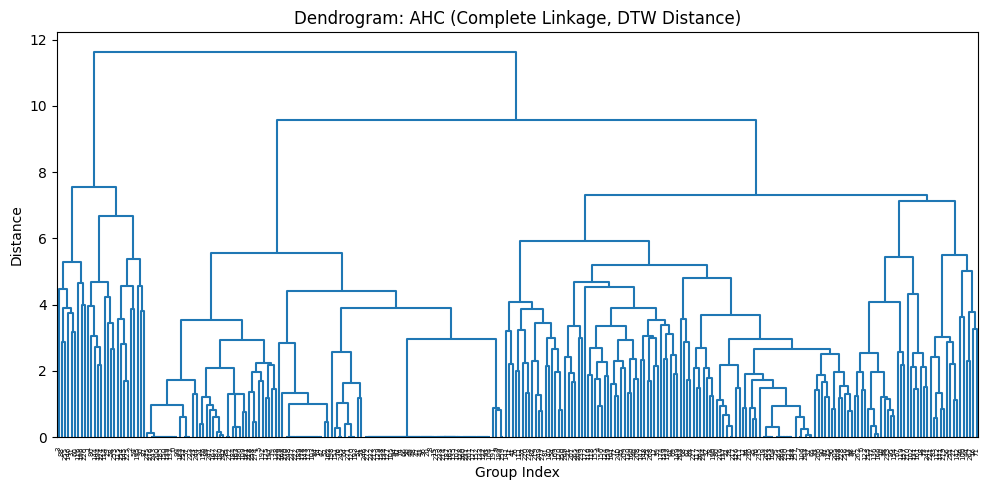

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# 5d. Visualization Helpers

def plot_dendrogram(Z):
    plt.figure(figsize=(10, 5))
    dendrogram(Z, color_threshold=0)
    plt.title('Dendrogram: AHC (Complete Linkage, DTW Distance)')
    plt.xlabel('Group Index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

# Convert DTW distance matrix to condensed form
D_dtw_condensed = squareform(D_dtw)  # Needed for scipy's linkage()

# Perform hierarchical clustering
Z = linkage(D_dtw_condensed, method='complete')

# Plot the dendrogram
plot_dendrogram(Z)


## 6a. Tune AHC cluster count using silhouette score
We evaluate different numbers of clusters using the silhouette score computed from the DTW distance matrix.


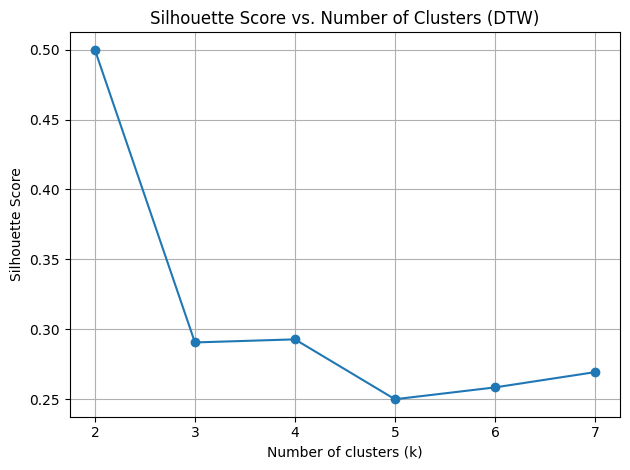

Optimal clusters by silhouette (DTW): 2


In [8]:
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# --- 6a. Parameter Tuning for AHC using DTW ---
sil_scores = []

for k in range(2, 8):
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='complete')
    labels = model.fit_predict(D_dtw)
    
    # Silhouette score using DTW distance matrix
    sil = silhouette_score(D_dtw, labels, metric='precomputed')
    sil_scores.append({'k': k, 'silhouette': sil})

sil_df = pd.DataFrame(sil_scores)

# Plot silhouette scores
plt.figure()
plt.plot(sil_df['k'], sil_df['silhouette'], marker='o')
plt.title('Silhouette Score vs. Number of Clusters (DTW)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Choose optimal k
opt_k = sil_df.loc[sil_df['silhouette'].idxmax(), 'k']
print(f"Optimal clusters by silhouette (DTW): {opt_k}")

# --- 6b. Density-based clustering using DBSCAN with DTW ---
def run_dbscan(D: np.ndarray, eps: float, min_samples: int = 5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = db.fit_predict(D)
    return labels

# Example run (adjust `eps` to tune)
# dbscan_labels = run_dbscan(D_dtw, eps=100)


## 7. Run final clustering using AHC and DBSCAN/HDBSCAN
We use the optimal number of clusters to assign group labels to each time series using both clustering methods.


In [9]:
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# --- 7. Clustering Execution using DTW ---

# AHC with optimal k from silhouette
Z = linkage(squareform(D_dtw), method='complete')
labels_ahc = AgglomerativeClustering(
    n_clusters=int(opt_k), 
    metric='precomputed', 
    linkage='complete'
).fit_predict(D_dtw)

# HDBSCAN (fallback to DBSCAN if not installed)
try:
    import hdbscan
    labels_hdb = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=10).fit_predict(D_dtw)
except ImportError:
    print("HDBSCAN not installed. Falling back to DBSCAN.")
    labels_hdb = DBSCAN(eps=np.median(D_dtw), min_samples=5, metric='precomputed').fit_predict(D_dtw)


## 8. Compute evaluation metrics for each clustering method
We calculate silhouette scores to assess cluster quality. Other metrics like Davies-Bouldin and Calinski-Harabasz are skipped due to DTW incompatibility.


In [10]:
# 8. Evaluation Metrics (DTW-only)

def compute_metrics(labels, D_dtw):
    metrics = {}
    # Silhouette score on precomputed DTW distance
    metrics['silhouette'] = silhouette_score(D_dtw, labels, metric='precomputed') \
        if len(set(labels)) > 1 else np.nan

    # Davies-Bouldin and Calinski-Harabasz require feature vectors, so we skip them
    metrics['db'] = np.nan
    metrics['ch'] = np.nan
    return metrics

# Compute metrics for AHC and Density-based clustering
metrics = pd.DataFrame({
    'AHC': compute_metrics(labels_ahc, D_dtw),
    'Density': compute_metrics(labels_hdb, D_dtw)
}).T

print(metrics)


         silhouette  db  ch
AHC        0.499878 NaN NaN
Density    0.181255 NaN NaN


## 9. Visualize dendrogram and silhouette plot for AHC clusters
We plot the dendrogram and silhouette plot to assess how well-separated the DTW-based clusters are.


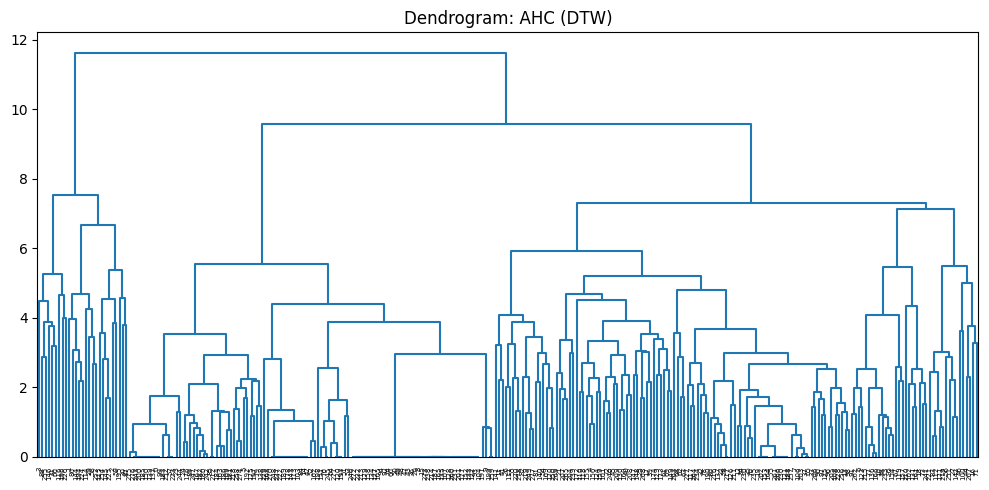

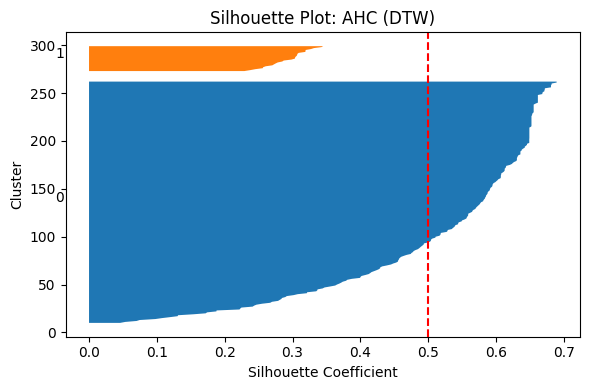

In [11]:
# 9. Visualizations (DTW-Only)

# --- Dendrogram ---
plt.figure(figsize=(10, 5))
_ = dendrogram(Z, color_threshold=0)
plt.title('Dendrogram: AHC (DTW)')
plt.tight_layout()
plt.show()

# --- Silhouette Plot for AHC using DTW ---
from sklearn.metrics import silhouette_samples

sample_sil = silhouette_samples(D_dtw, labels_ahc, metric='precomputed')

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.set_title('Silhouette Plot: AHC (DTW)')
ax1.set_xlabel('Silhouette Coefficient')
ax1.set_ylabel('Cluster')

y_lower = 10
for i in range(int(opt_k)):
    ith_sil = sample_sil[labels_ahc == i]
    ith_sil.sort()
    size = ith_sil.shape[0]
    y_upper = y_lower + size

    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil)
    ax1.text(-0.05, y_lower + 0.5 * size, str(i))
    y_lower = y_upper + 10

# Average silhouette score line
ax1.axvline(x=metrics.loc['AHC', 'silhouette'], color="red", linestyle="--")

plt.tight_layout()
plt.show()


## 10. Visualize time series for the first 3 AHC clusters
We display up to 5 sample time series per cluster to help interpret behavioral patterns.


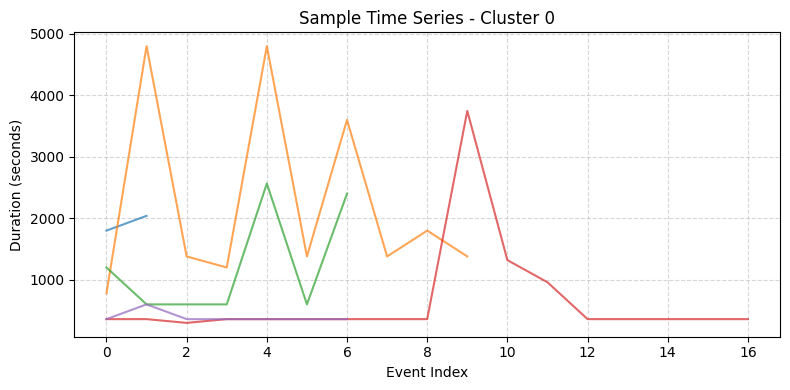

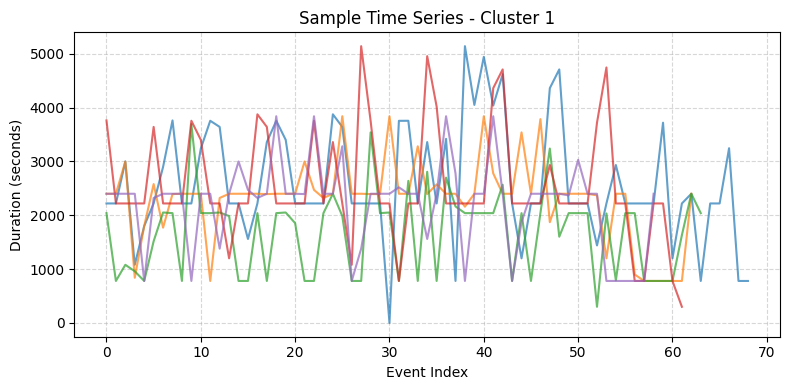

In [12]:
# 10. Clustered Time-Series Samples (first 3 clusters)

for cluster_id in range(min(3, int(opt_k))):
    plt.figure(figsize=(8, 4))
    plt.title(f"Sample Time Series - Cluster {cluster_id}")

    # Get time series keys for the current cluster
    keys = [k for k, l in zip(ts_dict.keys(), labels_ahc) if l == cluster_id]

    # Plot up to 5 sample sequences from this cluster
    for key in keys[:5]:
        plt.plot(ts_dict[key], alpha=0.7)

    plt.xlabel('Event Index')
    plt.ylabel('Duration (seconds)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## 11. Export cluster assignments and evaluation metrics
The final results are saved to `.csv` files for further analysis or reporting.


In [13]:
# 11. Export Results

# Ensure labels are mapped correctly to stats index (MultiIndex)
index_keys = list(ts_dict.keys())
stats.loc[index_keys, 'AHC_label'] = labels_ahc
stats.loc[index_keys, 'Density_label'] = labels_hdb

# Export results
metrics.to_csv('clustering_metrics_stage1.csv')
stats.to_csv('cluster_assignments_stage1.csv')
print("Exports complete.")


Exports complete.


In [14]:
# Save ts_dict to file for dashboard use
import numpy as np

np.save('ts_dict_stage1.npy', ts_dict)
print("✅ ts_dict saved as ts_dict_stage1.npy")


✅ ts_dict saved as ts_dict_stage1.npy


In [15]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Ensure Z is already defined using: Z = linkage(squareform(D_dtw), method='complete')

# Save dendrogram as PNG
plt.figure(figsize=(12, 5))
dendrogram(Z, color_threshold=0)
plt.title("Dendrogram: AHC from DTW Distance Matrix")
plt.xlabel("Group Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig("dendrogram_snapshot.png", dpi=300)
plt.close()

print("✅ Dendrogram saved as dendrogram_snapshot.png")


✅ Dendrogram saved as dendrogram_snapshot.png
